# Process `thaiqa` Dataset for [huggingface/datasets](https://github.com/huggingface/datasets/)

In [68]:
import json
import glob
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pythainlp.tokenize import word_tokenize

In [2]:
fnames = glob.glob('thaiqa_raw/*.json')
#first two from [@kobkrit](https://github.com/kobkrit) who is the winner of 2020 competition; 
#last one from https://aiforthai.in.th/corpus.php
fnames 

['thaiqa_raw/nectec-dev.json',
 'thaiqa_raw/nectec-train.json',
 'thaiqa_raw/ThaiQACorpus-DevelopmentDataset 2.json']

In [24]:
train = pd.DataFrame(json.load(open(fnames[1],'r'))['data'])
dev = pd.DataFrame(json.load(open(fnames[0],'r'))['data'])
#remove duplicates from dev
dev = dev[~dev.question.isin(train.question)].reset_index(drop=True)

#strip space in answer_begins_position
train.columns = [i.strip() for i in train.columns]
dev.columns = [i.strip() for i in dev.columns]

# forthai = pd.DataFrame(json.load(open(fnames[2],'r'))['data']) #same as train
dev.shape,train.shape #,forthai.shape

((74, 6), (4000, 6))

## Change to SQuAD format

In [4]:
wiki_names = glob.glob('thaiqa_raw/documents-nsc/*.txt')
len(wiki_names), wiki_names[:10]

(125302,
 ['thaiqa_raw/documents-nsc/285586.txt',
  'thaiqa_raw/documents-nsc/806049.txt',
  'thaiqa_raw/documents-nsc/760931.txt',
  'thaiqa_raw/documents-nsc/132592.txt',
  'thaiqa_raw/documents-nsc/582918.txt',
  'thaiqa_raw/documents-nsc/878583.txt',
  'thaiqa_raw/documents-nsc/766398.txt',
  'thaiqa_raw/documents-nsc/444181.txt',
  'thaiqa_raw/documents-nsc/708441.txt',
  'thaiqa_raw/documents-nsc/323433.txt'])

In [5]:
wiki_dfs = []
for wiki_name in tqdm(wiki_names):
    with open(wiki_name,'r') as f:
        line = f.readline()
#         soup = BeautifulSoup(line)
#         text = soup.text
        wiki_dfs.append({'article_id':wiki_name.split('/')[-1].split('.')[0],'context':line})
wiki_df = pd.DataFrame(wiki_dfs)
wiki_df['article_id'] = wiki_df.article_id.astype(int)
wiki_df

,article_id,context
0,285586,"<doc id=""285586"" url=""https://th.wikipedia.org..."
1,806049,"<doc id=""806049"" url=""https://th.wikipedia.org..."
2,760931,"<doc id=""760931"" url=""https://th.wikipedia.org..."
3,132592,"<doc id=""132592"" url=""https://th.wikipedia.org..."
4,582918,"<doc id=""582918"" url=""https://th.wikipedia.org..."
...,...,...
125297,94304,"<doc id=""94304"" url=""https://th.wikipedia.org/..."
125298,776192,"<doc id=""776192"" url=""https://th.wikipedia.org..."
125299,932487,"<doc id=""932487"" url=""https://th.wikipedia.org..."
125300,29685,"<doc id=""29685"" url=""https://th.wikipedia.org/..."


In [40]:
train = train.merge(wiki_df, on='article_id')
dev = dev.merge(wiki_df, on='article_id')
train['answer_begin_position']-=1
dev['answer_begin_position']-=1
train['answer_end_position']-=1
dev['answer_end_position']-=1
train.shape,dev.shape

((4000, 7), (74, 7))

In [45]:
#check if answers corresponds position
(train.answer==train.apply(lambda row: 
                          row['context'][int(row['answer_begin_position']):int(row['answer_end_position'])],1)).mean()

1.0

In [46]:
#check if answers corresponds position
(dev.answer==dev.apply(lambda row: 
                          row['context'][int(row['answer_begin_position']):int(row['answer_end_position'])],1)).mean()

1.0

In [49]:
dev.shape,train.shape

((74, 7), (4000, 7))

In [53]:
#save
train.to_json('data/train.json;',orient='records',lines=True)
dev.to_json('data/dev.jsonl',orient='records',lines=True)

## Exploration

### Questions

In [58]:
#2289 articles out of 4000 questions for train; all unique articles for all 74 dev questions
train.shape, train.article_id.nunique(), dev.shape, dev.article_id.nunique()

((4000, 7), 2289, (74, 7), 74)

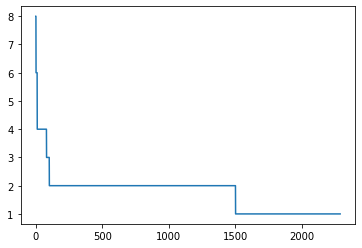

In [67]:
#most articles feature in 1-2 questions
plt.plot(train.article_id.value_counts().tolist())

### Word Counts

In [69]:
#word counts
train['nb_context'] = train.context.map(lambda x: len(word_tokenize(x)))
train['nb_question'] = train.question.map(lambda x: len(word_tokenize(x)))
train['nb_answer'] = train.answer.map(lambda x: len(word_tokenize(x)))

In [77]:
train.nb_context.describe()

count     4000.000000
mean      1186.740750
std       2044.117592
min         55.000000
25%        281.000000
50%        526.500000
75%       1168.500000
max      21353.000000
Name: nb_context, dtype: float64

<AxesSubplot:>

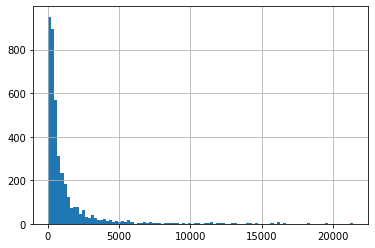

In [71]:
train.nb_context.hist(bins=100)

In [78]:
train.nb_question.describe()

count    4000.000000
mean       14.325500
std         5.578201
min         3.000000
25%        10.000000
50%        13.000000
75%        18.000000
max        38.000000
Name: nb_question, dtype: float64

<AxesSubplot:>

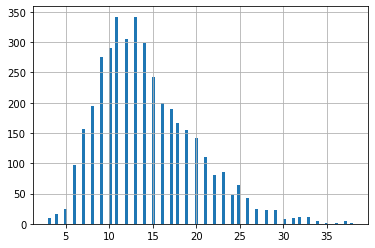

In [76]:
train.nb_question.hist(bins=100)

In [79]:
train.nb_answer.describe()

count    4000.000000
mean        3.279750
std         2.820191
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        31.000000
Name: nb_answer, dtype: float64

<AxesSubplot:>

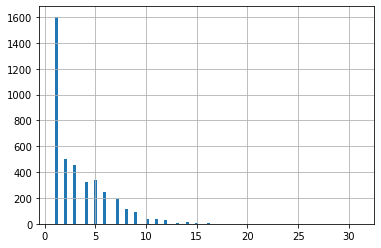

In [72]:
train.nb_answer.hist(bins=100)

In [80]:
#word counts
dev['nb_context'] = dev.context.map(lambda x: len(word_tokenize(x)))
dev['nb_question'] = dev.question.map(lambda x: len(word_tokenize(x)))
dev['nb_answer'] = dev.answer.map(lambda x: len(word_tokenize(x)))

In [81]:
dev.nb_context.describe()

count       74.000000
mean      1016.459459
std       1897.453710
min         64.000000
25%        257.000000
50%        496.500000
75%        972.500000
max      14294.000000
Name: nb_context, dtype: float64

<AxesSubplot:>

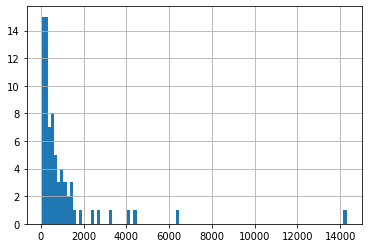

In [82]:
dev.nb_context.hist(bins=100)

In [83]:
dev.nb_question.describe()

count    74.000000
mean     12.743243
std       5.104553
min       5.000000
25%       9.000000
50%      12.000000
75%      17.000000
max      32.000000
Name: nb_question, dtype: float64

<AxesSubplot:>

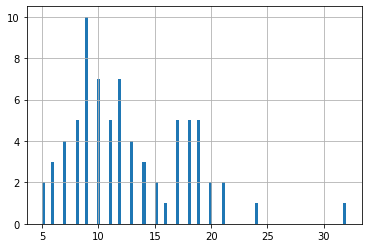

In [84]:
dev.nb_question.hist(bins=100)

In [85]:
dev.nb_answer.describe()

count    74.000000
mean      4.608108
std       3.891746
min       1.000000
25%       2.000000
50%       4.000000
75%       6.000000
max      23.000000
Name: nb_answer, dtype: float64

<AxesSubplot:>

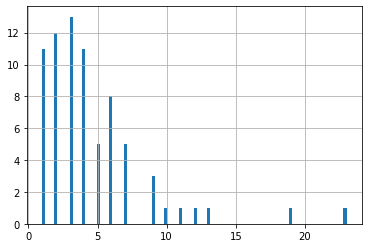

In [86]:
dev.nb_answer.hist(bins=100)